# Extract Stats from Basketball-Reference.com

2017-11

Scrap data from basketball-reference.com, using pd.read_html, BeaultifulSoup, Multiprocessing, & Other python modules.

## Imports, Constants, Utilities

### Imports

In [302]:
%%time

import os
import sys
import datetime
import re

import json
import pickle
import urllib
import pandas as pd
import numpy as np
import google
import random
import time
import multiprocessing
import gspread
import unidecode
import tqdm
import pprint

from collections import OrderedDict
from gspread import WorksheetNotFound
from bs4 import BeautifulSoup
from oauth2client.service_account import ServiceAccountCredentials

DATETIME_STRING_FORMAT = '%Y-%m-%d %H:%M:%S'

CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 31.9 µs


In [124]:
%%time

def merge_list_of_list(nested_list):
    flattened_list = [item for lst in nested_list for item in lst]
    return flattened_list

test_list = [['a'], ['b']]
merge_list_of_list(test_list)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 11.9 µs


In [125]:
%%time

# Utility function to merge retrived data tables into 1 dictionary.
def merge_list_of_dict(list_of_dict):
    merged_dict = {}
    for dictionary in list_of_dict:
        merged_dict.update(dictionary)
    # Sort by dictionary key
    ordered_dict = OrderedDict(sorted(merged_dict.items(), key=lambda t: t[0]))
    return ordered_dict

test_list = [
    {'michael jordan': {'tables': {}, 'missing_tables': 'none', 'url': 'diety'}},
    {'kobe bryant': {'tables': {}, 'missing_tables': 'none', 'url': 'godly'}},
]

dic = merge_list_of_dict(test_list)
print(dic)

OrderedDict([('kobe bryant', {'tables': {}, 'missing_tables': 'none', 'url': 'godly'}), ('michael jordan', {'tables': {}, 'missing_tables': 'none', 'url': 'diety'})])
CPU times: user 154 µs, sys: 149 µs, total: 303 µs
Wall time: 161 µs


In [247]:
%%time

def sanitize_string(raw_string):
    sanitized_string = unidecode.unidecode(raw_string)
    sanitized_string = sanitized_string.strip().lower()
    sanitized_string = sanitized_string.replace("'", "")
    sanitized_string = sanitized_string.replace('"', '') 
    sanitized_string = sanitized_string.replace('.', '')
    if "," in sanitized_string:
        lst = sanitized_string.split(",")
        lst.reverse()
        lst = [token.strip() for token in lst]
        sanitized_string = " ".join(lst)
    return sanitized_string

print(sanitize_string("Shaquille O'neal"))
print(sanitize_string("Bryant, Kobe"))
print(sanitize_string(" CarTer, Vince .."))

shaquille oneal
kobe bryant
vince carter
shooting guard and small forward    

#
CPU times: user 1.22 ms, sys: 2.32 ms, total: 3.53 ms
Wall time: 3.78 ms


In [127]:
%%time

def sanitize_list(raw_list):
            
    sanitized_list = [sanitize_string(raw_string) for raw_string in raw_list]
    return sanitized_list

test_list = ["Shaquille O'neal", "J. J. Reddick", "VinCe Carter ", "Bryant, Kobe"]

print(sanitize_list(test_list))

['shaquille oneal', 'j j reddick', 'vince carter', 'kobe bryant']
CPU times: user 313 µs, sys: 261 µs, total: 574 µs
Wall time: 370 µs


In [128]:
%%time

def dedupe_list(lst):
    return list(set(lst))

print(dedupe_list(['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', ]))

['a', 'b']
CPU times: user 60 µs, sys: 25 µs, total: 85 µs
Wall time: 88.7 µs


### Load Spreadsheets

In [129]:
def load_list_from_worksheet(spreadsheet_name, worksheet_name):
  
    scope = ['https://spreadsheets.google.com/feeds']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('Data-35df9a696bc1.json', scope)
    gc = gspread.authorize(credentials)

    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.worksheet(worksheet_name)

    rows = worksheet.get_all_values()
    
    first_row = rows[0]
    first_cell = first_row[0]
    
    try:
        timestamp = datetime.datetime.strptime(first_cell, DATETIME_STRING_FORMAT)
        rows.remove(first_row)
    except ValueError:
        timestamp = None

    print(
        'LOADED > {num_rows} rows from '
        'spreadsheet: "{spreadsheet_name}" | '
        'worksheet: "{worksheet_name}" | '
        'timestamp: {timestamp}'.format(
            num_rows=len(rows), spreadsheet_name=spreadsheet_name, 
            worksheet_name=worksheet_name, timestamp=timestamp), '\n')

    df = merge_list_of_list(rows)
    
    return df

worksheet = load_list_from_worksheet('test_spreadsheet', 'test')
print(worksheet[:10])

LOADED > 100 rows from spreadsheet: "test_spreadsheet" | worksheet: "test" | timestamp: 2017-11-23 10:19:18 

['michale', 'kobe', '0', '1', '2', '3', '4', '5', '6', '7']


In [130]:
%%time

def save_list_to_worksheet(lst, spreadsheet_name, worksheet_name, add_timestamp=True, overwrite=False):
    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('Data-35df9a696bc1.json', scope)
    gc = gspread.authorize(credentials)
    
    spreadsheet = gc.open(spreadsheet_name)
    
    if type(lst) is not list:
        print('ERROR: input item is not a list!')
        return False
    
    # Remove rows with None value
    original_length = len(lst)
    lst = [item for item in lst if item is not None]
    new_length = len(lst)
    
    try:
        worksheet = spreadsheet.worksheet(worksheet_name)
        if overwrite:
            new_worksheet_name = worksheet_name + "_new"
            new_worksheet = spreadsheet.add_worksheet(new_worksheet_name, len(lst), 1)
            spreadsheet.del_worksheet(worksheet)
            new_worksheet.update_title(worksheet_name)
        else:
            print('Worksheet "{worksheet_name}" already exist! Please set overwrite=True to overwrite.')
            return False
    except WorksheetNotFound: 
        new_worksheet = spreadsheet.add_worksheet(worksheet_name, len(lst), 1)
    
    range_notation = 'A1:A{last_row_index}'.format(last_row_index=len(lst))
    
    cells_to_update = new_worksheet.range(range_notation)

    print('Remove {num_row} rows with "None" as their value.'.format(
        num_row=(original_length - new_length)))
    
    for cell, item in zip(cells_to_update, lst):
        cell.value = item
    
    new_worksheet.update_cells(cells_to_update)
    
    #Add a timestamp in the 1st cell
    if add_timestamp:
        timestamp = datetime.datetime.now()
        new_worksheet.insert_row(
            [timestamp], 1)
    
    print(
    'SAVED > {num_rows} rows to '
    'spreadsheet: "{spreadsheet_name}" | '
    'worksheet: "{worksheet_name}" | '
    'timestamp: {timestamp}'.format(
        num_rows=len(lst), spreadsheet_name=spreadsheet_name, 
        worksheet_name=worksheet_name, timestamp=timestamp), '\n')
    
    return True

test_lst = ['michale', 'kobe'] + [i for i in range(98)]
print(len(test_lst))
save_list_to_worksheet(test_lst, 'test_spreadsheet', 'test', add_timestamp=True, overwrite=True)

100
Remove 0 rows with "None" as their value.
SAVED > 100 rows to spreadsheet: "test_spreadsheet" | worksheet: "test" | timestamp: 2017-11-23 11:35:55.918565 

CPU times: user 103 ms, sys: 14.9 ms, total: 118 ms
Wall time: 3.11 s


### Save & Load Pickle

In [131]:
%%time

test = {
    'words': """
        Lorem ipsum dolor sit amet, consectetur adipiscing 
        elit. Mauris adipiscing adipiscing placerat. 
        Vestibulum augue augue, 
        pellentesque quis sollicitudin id, adipiscing.
        """,
    'list': list(range(10000)),
    'dict': dict((str(i),'a') for i in range(10000)),
    'int': 100,
    'float': 100.123456
}

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def get_file_size(filename):
    statinfo = os.stat(filename)
    return sizeof_fmt(statinfo.st_size)

def save_pickle(item, filename):
    with open(filename, 'wb') as file:
        pickle.dump(item, file)
    print(
        '\n'
        'SAVED  > ',
        filename, ' | ', 
        get_file_size(filename), ' | ',
        'length: ', len(item),
        '\n')
    return True;

def load_pickle(filename):
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
        print(
        '\n'
        'LOADED > ',
        filename, ' | ', 
        get_file_size(filename), ' | ',
        'length: ', len(obj),
        '\n')
        return obj

save_pickle(test, 'test.pickle')

len(load_pickle('test.pickle'))


SAVED  >  test.pickle  |  183.8 KiB  |  length:  5 


LOADED >  test.pickle  |  183.8 KiB  |  length:  5 

CPU times: user 11 ms, sys: 3.52 ms, total: 14.5 ms
Wall time: 13.4 ms


### Define & Load Constants

In [132]:
%%time

# Tables to retrieve for each player, by table html ids
TABLE_IDS = [
  'per_game',
  'totals',
  'per_minute', # per 36 minutes
  'per_poss', # per 100 possessions
  'advanced', # advanced
    
  'playoffs_per_game',
  'playoffs_totals',
  'playoffs_per_minute', # playoffs per 36 minutes
  'playoffs_per_poss', # playoffs per 100 possessions
  'playoffs_advanced', 
    
  'all_star',
  'all_college_stats',
  'all_salaries',
]

print('Current TABLE_IDS length: ', len(TABLE_IDS))

# Load player names
hof_names = sanitize_list(
    load_list_from_worksheet('nba_player_names', 'hof_names'))
retired_all_stars_names = sanitize_list(
    load_list_from_worksheet('nba_player_names', 'retired_all_stars_names'))
retired_all_nbas_names = sanitize_list(
    load_list_from_worksheet('nba_player_names', 'retired_all_nbas_names'))
players_2015_names = sanitize_list(
    load_list_from_worksheet('nba_player_names', 'players_2015_names'))

# Load URLs
hof_urls = load_list_from_worksheet('nba_player_urls', 'hof_urls')
retired_all_stars_urls = load_list_from_worksheet('nba_player_urls', 'retired_all_stars_urls')
retired_all_nbas_urls = load_list_from_worksheet('nba_player_urls', 'retired_all_nbas_urls')
players_2015_urls = load_list_from_worksheet('nba_player_urls', 'players_2015_urls')

Current TABLE_IDS length:  13
LOADED > 181 rows from spreadsheet: "nba_player_names" | worksheet: "hof_names" | timestamp: None 

LOADED > 352 rows from spreadsheet: "nba_player_names" | worksheet: "retired_all_stars_names" | timestamp: None 

LOADED > 191 rows from spreadsheet: "nba_player_names" | worksheet: "retired_all_nbas_names" | timestamp: None 

LOADED > 476 rows from spreadsheet: "nba_player_names" | worksheet: "players_2015_names" | timestamp: None 

LOADED > 131 rows from spreadsheet: "nba_player_urls" | worksheet: "hof_urls" | timestamp: 2017-11-21 13:21:32 

LOADED > 352 rows from spreadsheet: "nba_player_urls" | worksheet: "retired_all_stars_urls" | timestamp: 2017-11-21 13:21:41 

LOADED > 190 rows from spreadsheet: "nba_player_urls" | worksheet: "retired_all_nbas_urls" | timestamp: 2017-11-21 13:21:36 

LOADED > 476 rows from spreadsheet: "nba_player_urls" | worksheet: "players_2015_urls" | timestamp: 2017-11-21 13:21:46 

CPU times: user 519 ms, sys: 81.6 ms, total: 6

## Get Players

### Get players from a single URL

In [133]:
def get_players(url):
    
    href_pattern = re.compile('^\/players\/.\/[a-z0-9]*.html$')
    href_prefix = 'https://www.basketball-reference.com'
    
    page = urllib.request.urlopen(url)
    html = page.read()

    # Get the player name
    soup = BeautifulSoup(html, 'html.parser')
    
    els = soup.find_all('a', href=href_pattern)
    
    players = {}
    
    for el in els:
        if el.parent.name == 'td':
            player_name = sanitize_string(el.text)
            player_url = ''.join([href_prefix, el['href']])
            players[player_name] = player_url
    
    randomized_sleep_time = 2 + np.random.exponential(1, 1)[0]
    time.sleep(randomized_sleep_time)
    
    print('Scrapped {url} | Players Found: {len}'.format(url=url, len=len(players)))
    sys.stdout.flush()

    return players

players = get_players('https://www.basketball-reference.com/leagues/NBA_1967_totals.html')

Scrapped https://www.basketball-reference.com/leagues/NBA_1967_totals.html | Players Found: 123


### Get players from a list of URLs, Multiprocessing

In [134]:
%%time

def get_players_from_urls(urls, num_processes):
    p = multiprocessing.Pool(processes=num_processes)
    outputs = p.map(get_players, urls)
    p.close()
    final_output = merge_list_of_dict(outputs)
    print(
        'Scrapped {num_url} urls, found {num_player} players.'.format(
            num_url=len(urls), num_player=len(final_output)), '\n')
    return final_output

test_urls = [
    'https://www.basketball-reference.com/leagues/NBA_2015_totals.html',
    'https://www.basketball-reference.com/leagues/NBA_2010_totals.html'
]

players = get_players_from_urls(test_urls, 2)

Scrapped https://www.basketball-reference.com/leagues/NBA_2015_totals.html | Players Found: 492
Scrapped https://www.basketball-reference.com/leagues/NBA_2010_totals.html | Players Found: 442
Scrapped 2 urls, found 716 players. 

CPU times: user 14.6 ms, sys: 18.8 ms, total: 33.5 ms
Wall time: 8.99 s


## GET URL (DEPRECATED, replaced by "Get Players")

### Get URL for a player name

In [13]:
# %%time

# #TODO(jameshu): Add logic to verify the url returned  in fact matches the player name
# # Currently, even gibberish player_name e.g. "James Hu" would have results returned.

# def get_url_title(url):
#     page = urllib.request.urlopen(url)
#     soup = BeautifulSoup(page, "html.parser")
#     return soup.title.text

# def get_url(player_name):       
#     query = (
#         'site:www.basketball-reference.com/players/*/*.html '
#         '{player_name} Overview').format(player_name=player_name)
#     print('query: ', query)

#     results = google.search(query=query, start=0, stop=1)
#     urls = list(results)        
    
#     time.sleep(random.randint(5, 10))
    
#     if urls:
#         return {player_name: urls[0]}
#     else:
#         print('url found: None')
#         return {player_name: None}
        
# # print(get_url('Michael Jordan'))

### Get URLs for a list of player names, MULTIPROCESSING

In [14]:
# %%time

# def get_urls(player_names, num_processes):
#     p = multiprocessing.Pool(processes=num_processes)
#     outputs = p.map(get_url, player_names)
#     p.close()
#     return merge_list_of_dict(outputs)

# # print(get_urls(test_names[0:2], 2))

## Get stats tables

### Get stats table for an url

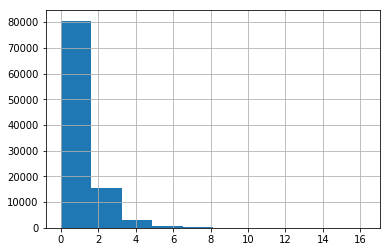

In [15]:
%matplotlib inline

# Test out the sleep function

# mu, sigma = 0, 1
# s = np.random.normal(mu, sigma, 1000)
# pd.Series(s).hist()

# mu, sigma = 0, 1
# s = np.random.exponential(1, 100000)
# pd.Series(s).hist()


In [135]:
%%time

def get_stats_table(url):
        
    output = {}
    
    page = urllib.request.urlopen(url)
    urlHtml = page.read().decode()
    
    # Uncomment the tables
    uncommentedUrlHtml = urlHtml.replace('-->', '')
    uncommentedUrlHtml = uncommentedUrlHtml.replace('<!--', '')

    soup = BeautifulSoup(uncommentedUrlHtml, 'lxml')
    
    player_name = sanitize_string(soup.find("h1").text)
    output.setdefault(player_name, {}).setdefault('url', url);

    tags = soup.find_all('table')
    
    tables = {}
    missing_table_ids = list(TABLE_IDS) # MAKE A COPY
    
    for tag in tags:
        table_id = tag.get('id')
        if table_id in TABLE_IDS:
            table = pd.read_html(str(tag), header=0, index_col=0)[0]
            tables[table_id] = table
            missing_table_ids.remove(table_id)

    for dataframe in tables.values():
        dataframe.drop([col_name for col_name in dataframe.columns if 'Unnamed' in col_name], axis=1, inplace=True)
       
    output[player_name].setdefault('tables', tables);
    output[player_name].setdefault('missing_tables', missing_table_ids);
    
    randomized_sleep_time = 2 + np.random.exponential(1, 1)[0]
    time.sleep(randomized_sleep_time)
    
    processing_info = (
        '{player_name} | Found: {num_table} | '
        'slept: {randomized_sleep_time}'.format(
            player_name=player_name, 
            num_table=len(output[player_name]['tables']), 
            missing_tables=missing_table_ids,
            randomized_sleep_time=randomized_sleep_time))
    
    print(processing_info)
    sys.stdout.flush()

    return output

table = get_stats_table('https://www.basketball-reference.com/players/b/bellawa01.html')

walt bellamy | Found: 11 | slept: 3.9688309966135367
CPU times: user 784 ms, sys: 26.1 ms, total: 810 ms
Wall time: 5.31 s


In [18]:
table['walt bellamy']['tables']['totals']

,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,FG%,...,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,PF,PTS
Season,,,,,,,,,,,,,,,,,,,,,
1961-62,22.0,CHP,NBA,C,79,NaN,3344,973,1875,0.519,...,853,0.644,NaN,NaN,1500,210,NaN,NaN,281,2495
1962-63,23.0,CHZ,NBA,C,80,NaN,3306,840,1595,0.527,...,821,0.674,NaN,NaN,1309,233,NaN,NaN,283,2233
1963-64,24.0,BAL,NBA,C,80,NaN,3394,811,1582,0.513,...,825,0.651,NaN,NaN,1361,126,NaN,NaN,300,2159
1964-65,25.0,BAL,NBA,C,80,NaN,3301,733,1441,0.509,...,752,0.685,NaN,NaN,1166,191,NaN,NaN,260,1981
1965-66,26.0,TOT,NBA,C,80,NaN,3352,695,1373,0.506,...,689,0.624,NaN,NaN,1254,235,NaN,NaN,294,1820
1965-66,26.0,BAL,NBA,C,8,NaN,268,56,124,0.452,...,67,0.597,NaN,NaN,102,18,NaN,NaN,32,152
1965-66,26.0,NYK,NBA,C,72,NaN,3084,639,1249,0.512,...,622,0.627,NaN,NaN,1152,217,NaN,NaN,262,1668
1966-67,27.0,NYK,NBA,C,79,NaN,3010,565,1084,0.521,...,580,0.636,NaN,NaN,1064,206,NaN,NaN,275,1499
1967-68,28.0,NYK,NBA,C,82,NaN,2695,511,944,0.541,...,529,0.662,NaN,NaN,961,164,NaN,NaN,259,1372


In [19]:
table['walt bellamy']['missing_tables']

['playoffs_per_poss', 'all_salaries']

In [20]:
table['walt bellamy']['url']

'https://www.basketball-reference.com/players/b/bellawa01.html'

### Get stats tables for a list of urls, MULTIPROCESSING

In [136]:
%%time

def get_stats_tables(urls, num_processes):
    pool = multiprocessing.Pool(processes=num_processes)
    jobs = pool.imap_unordered(get_stats_table, urls)
    size = len(urls)
    outputs = tqdm.tqdm_notebook(jobs, total=size)
    pool.close()
#     pool.join()
    return merge_list_of_dict(outputs)

test_urls = [
    'https://www.basketball-reference.com/players/b/bellawa01.html',
    'https://www.basketball-reference.com/players/j/jordami01.html'
]

tables = get_stats_tables(test_urls, 2)
print('obj length: ', len(tables))

A Jupyter Widget

michael jordan | Found: 13 | slept: 2.6244218457053075
walt bellamy | Found: 11 | slept: 2.6244218457053075

obj length:  2
CPU times: user 49.6 ms, sys: 27.8 ms, total: 77.5 ms
Wall time: 5.23 s


In [22]:
tables['michael jordan']['tables']

{'advanced':           Age   Tm   Lg  Pos     G     MP   PER    TS%   3PAr    FTr  ...    \
 Season                                                                ...     
 1984-85  21.0  CHI  NBA   SG    82   3144  25.8  0.592  0.032  0.459  ...     
 1985-86  22.0  CHI  NBA   SG    18    451  27.5  0.533  0.055  0.381  ...     
 1986-87  23.0  CHI  NBA   SG    82   3281  29.8  0.562  0.029  0.427  ...     
 1987-88  24.0  CHI  NBA   SG    82   3311  31.7  0.603  0.027  0.430  ...     
 1988-89  25.0  CHI  NBA   SG    81   3255  31.1  0.614  0.055  0.442  ...     
 1989-90  26.0  CHI  NBA   SG    82   3197  31.2  0.606  0.125  0.356  ...     
 1990-91  27.0  CHI  NBA   SG    82   3034  31.6  0.605  0.051  0.365  ...     
 1991-92  28.0  CHI  NBA   SG    80   3102  27.7  0.579  0.055  0.325  ...     
 1992-93  29.0  CHI  NBA   SG    78   3067  29.7  0.564  0.115  0.284  ...     
 1994-95  31.0  CHI  NBA   SG    17    668  22.1  0.493  0.079  0.337  ...     
 1995-96  32.0  CHI  NBA   S

## Get Player Attributes

### Get a player's attributes from an URL

In [406]:
%%time


def get_player_attributes(url):

    output = {}
    
    try:

        page = urllib.request.urlopen(url)
        urlHtml = page.read().decode()

        # Uncomment the tables
        uncommentedUrlHtml = urlHtml.replace('-->', '')
        uncommentedUrlHtml = uncommentedUrlHtml.replace('<!--', '')

        soup = BeautifulSoup(uncommentedUrlHtml, 'lxml')

        player_name = sanitize_string(soup.find("h1").text)
        output.setdefault(player_name, {}).setdefault('url', url)
        output.setdefault(player_name, {}).setdefault('missing_attributes', [])

        # Get all info, for future extraction
        player_info = soup.find('div', attrs={'id': 'info'})
        # output['player_info_raw'] = player_info

        tag = player_info.find('strong',text=re.compile('.*Position:.*'))
        if tag:
            position = tag.parent.contents[2]
            position = position.replace('\n','').replace('▪','').strip()
            position = re.sub('\s{2,}', ' ', position)
            shooting_hand = tag.parent.contents[-1]
            shooting_hand = shooting_hand.replace('\n','').replace('▪','').strip()
            shooting_hand = re.sub('\s{2,}', ' ', shooting_hand)
            output[player_name]['position'] = position
            output[player_name]['shooting_hand'] = shooting_hand
        else:
            output[player_name]['missing_attributes'].extend(['position', 'shooting_hand'])

        tag = player_info.find('strong',text=re.compile('.*High School:.*'))
        if tag:
            school = tag.parent.text.replace('\n', '').split(':')
            school = school[-1].strip()
            school = re.sub('\s{2,}', ' ', school)
            output[player_name]['high_school'] = school
        else:
            output[player_name]['missing_attributes'].append('high_school')

        tag = player_info.find('strong',text=re.compile('.*College:.*'))
        if tag:
            college = tag.parent.find('a').text.strip()
            output[player_name]['college'] = college
        else:
            output[player_name]['missing_attributes'].append('college')

        tag = player_info.find('strong',text=re.compile('.*Recruiting Rank:.*'))
        if tag:
            recruiting_rank = tag.parent.text.strip()
            recruiting_rank = re.search('\(([0-9]*)\)', recruiting_rank).group(1)
            output[player_name]['recruiting_rank'] = recruiting_rank
        else:
            output[player_name]['missing_attributes'].append('recruiting_rank')

        tag = player_info.find('strong',text=re.compile('.*Draft:.*'))
        if tag:
            draft = tag.parent.text.replace('\n', '').split(':')
            draft = draft[-1].strip()
            draft = re.sub('\s{2,}', ' ', draft)
            output[player_name]['draft'] = draft
        else:
            output[player_name]['missing_attributes'].append('draft')

        tag = player_info.find('strong',text=re.compile('.*Debut:.*'))
        if tag:
            nba_debute = tag.parent.contents[2]
            output[player_name]['nba_debut'] = nba_debute.text.strip()
        else:
            output[player_name]['missing_attributes'].append('nba_debut')            

        href_pattern = re.compile('^https://twitter.com/.*$')
        tag = player_info.find('a', href=href_pattern)
        if tag:
            output[player_name]['twitter'] = tag['href'].strip()
        else:
            output[player_name]['missing_attributes'].append('twitter')  

        tag = player_info.find('span', attrs={'itemprop': 'birthDate'})
        if tag:
            output[player_name]['birth_date'] = tag['data-birth'].strip()
        else:
            output[player_name]['missing_attributes'].append('birth_date')  

        tag = player_info.find('span', attrs={'itemprop': 'birthPlace'})
        if tag:
            output[player_name]['birth_place'] = tag.find('a').text.strip()
        else:
            output[player_name]['missing_attributes'].append('birth_place')  

        tag = player_info.find('span', attrs={'itemprop': 'height'})
        if tag:
            output[player_name]['height'] = tag.text.strip()
        else:
            output[player_name]['missing_attributes'].append('height')  

        tag = player_info.find('span', attrs={'itemprop': 'weight'})
        if tag:
            output[player_name]['weight'] = tag.text.strip()
        else:
            output[player_name]['missing_attributes'].append('weight')  

        tags = player_info.find('ul', attrs={'id': 'bling'})
        if tags:
            tags = tags.find_all('a')
            if tags:
                output[player_name]['honors'] = []
                for tag in tags:
                    output[player_name]['honors'].append(tag.text.strip())
            else:
                output[player_name]['missing_attributes'].append('honors')
        else:
            output[player_name]['missing_attributes'].append('honors')  

        tag = soup.find('p', text=re.compile('.*Chinese:.*'))
        if tag:
            chinese_name = tag.text.split(':')[-1].replace('數據','').strip()
            output[player_name]['chinese_name'] = chinese_name
        else:
            output[player_name]['missing_attributes'].append('chinese_name')  

        tags = soup.find_all('p', attrs={'class': 'transaction '})
        if tags:
            for tag in tags:
                transaction_date = tag.find('strong').text.strip()
                transaction = tag.text.split(':')[-1].strip()
                transaction = re.sub('\s{2,}', ' ', transaction)
                output[player_name].setdefault('transactions', {})[transaction_date] = transaction
        else:
            output[player_name]['missing_attributes'].append('transactions')  

        tag = player_info.find('p', text=re.compile('.*\(.*\).*'))
        if tag:
            nicknames = tag.text.replace('\n','').split(',')
            nicknames = [nickname.replace('(','').replace(')','').strip() for nickname in nicknames]
            output[player_name]['nicknames'] = nicknames
        else:
            output[player_name]['missing_attributes'].append('nicknames')  

        tags = player_info.find_all('svg', attrs={'class': 'jersey'})
        if tags:
            for tag in tags:
                jersey_number = tag.find('text').text.strip()
                team = tag.parent['data-tip'].strip()
                output[player_name].setdefault('numbers', {})[jersey_number] = team
        else:
            output[player_name]['missing_attributes'].append('numbers')  


        randomized_sleep_time = 3 + np.random.exponential(1, 1)[0]
        time.sleep(randomized_sleep_time)

        processing_info = (
            '{player_name} | Missing: {num_missing} | '
            'slept: {randomized_sleep_time}'.format(
                player_name=player_name, 
                num_missing=len(output[player_name]['missing_attributes']), 
                randomized_sleep_time=randomized_sleep_time))

        print(processing_info)
        sys.stdout.flush()
    
    except Exception as e:
        print(url, " FAILED! | ", str(e))
        output[url] = e
                
    return output

# test_url = 'https://www.basketball-reference.com/players/m/mingya01.html'
# test_url = "https://www.basketball-reference.com/players/b/bellawa01.html"
# test_url = 'https://www.basketball-reference.com/players/b/bryanko01.html'
# test_url = 'https://www.basketball-reference.com/players/r/redicjj01.html'
# test_url = 'https://www.basketball-reference.com/players/n/novakst01.html'
# test_url = 'https://www.basketball-reference.com/players/j/jordami01.html'
test_url = 'https://www.basketball-reference.com/players/h/hairsal01.html'
test_ulr = 'https://www.basketball-reference.com/players/h/henryal01.html'
    
test_output = get_player_attributes(test_url)
pprint.pprint(test_output)

https://www.basketball-reference.com/players/h/hairsal01.html  FAILED! |  <urlopen error [Errno 61] Connection refused>
{'https://www.basketball-reference.com/players/h/hairsal01.html': URLError(ConnectionRefusedError(61, 'Connection refused'),)}
CPU times: user 9.87 ms, sys: 2.54 ms, total: 12.4 ms
Wall time: 71.3 ms


In [400]:
%%time

def get_players_attributes(urls, num_processes):
    pool = multiprocessing.Pool(processes=num_processes)
    jobs = pool.imap_unordered(get_player_attributes, urls)
    size = len(urls)
    outputs = tqdm.tqdm_notebook(jobs, total=size)
    pool.close()
#     pool.join()
    return merge_list_of_dict(outputs)

test_urls = [
    'https://www.basketball-reference.com/players/b/bellawa01.html',
    'https://www.basketball-reference.com/players/j/jordami01.html',
    'https://www.basketball-reference.com/players/n/novakst01.html',
    'https://www.basketball-reference.com/players/m/mingya01.html',
    'https://www.basketball-reference.com/players/b/bryanko01.html',
    'https://www.basketball-reference.com/players/r/redicjj01.html'
]

attributes = get_players_attributes(test_urls, 4)
print('obj length: ', len(tables))

A Jupyter Widget

yao ming | Missing: 3 | slept: 2.784226089697289
steve novak | Missing: 3 | slept: 2.784226089697289
walt bellamy | Missing: 2 | slept: 2.784226089697289
jj redick | Missing: 2 | slept: 2.1640514141280347
michael jordan | Missing: 2 | slept: 2.784226089697289
kobe bryant | Missing: 2 | slept: 2.1640514141280347
obj length:  6
CPU times: user 75.8 ms, sys: 54.4 ms, total: 130 ms
Wall time: 12.3 s


## Run Tasks

### Get Names

In [392]:
%%time

leads_urls = load_list_from_worksheet('nba_player_names', 'leads_urls')

all_players = get_players_from_urls(leads_urls, 4)

LOADED > 69 rows from spreadsheet: "nba_player_names" | worksheet: "leads_urls" | timestamp: None 

Scrapped https://www.basketball-reference.com/leagues/NBA_1955_totals.html | Players Found: 105
Scrapped https://www.basketball-reference.com/leagues/NBA_1965_totals.html | Players Found: 114
Scrapped https://www.basketball-reference.com/leagues/NBA_1950_totals.html | Players Found: 223
Scrapped https://www.basketball-reference.com/leagues/NBA_1960_totals.html | Players Found: 99
Scrapped https://www.basketball-reference.com/leagues/NBA_1956_totals.html | Players Found: 92
Scrapped https://www.basketball-reference.com/leagues/NBA_1966_totals.html | Players Found: 111
Scrapped https://www.basketball-reference.com/leagues/NBA_1951_totals.html | Players Found: 135
Scrapped https://www.basketball-reference.com/leagues/NBA_1961_totals.html | Players Found: 93
Scrapped https://www.basketball-reference.com/leagues/NBA_1957_totals.html | Players Found: 99
Scrapped https://www.basketball-referenc

In [393]:
all_players['michael jordan']

'https://www.basketball-reference.com/players/j/jordami01.html'

In [394]:
len(all_players)

3998

In [26]:
# %%time

# all_players_stats_tables = get_stats_tables(list(all_players.values()), 4)

# save_pickle(all_players_stats_tables, 'all_players_stats_tables.pickle')

# print(all_players_stats_tables['lebron james']['tables'].keys())
# all_players_stats_tables['lebron james']['tables']['per_game']

A Jupyter Widget

aaron gordon | Found: 7 | slept: 2.5921689799732435
aaron brooks | Found: 12 | slept: 2.5921689799732435
aaron gray | Found: 12 | slept: 2.5921689799732435
aaron harrison | Found: 12 | slept: 2.5921689799732435
aaron james | Found: 5 | slept: 2.133234540871874
aaron miles | Found: 7 | slept: 2.133234540871874
aaron mckie | Found: 12 | slept: 2.133234540871874
aaron swinson | Found: 7 | slept: 2.133234540871874
abdel nader | Found: 6 | slept: 3.0675741461943007
abdul jeelani | Found: 6 | slept: 3.0675741461943007
aaron williams | Found: 12 | slept: 3.0675741461943007
acie earl | Found: 12 | slept: 2.0224826363033364
ac green | Found: 13 | slept: 3.0675741461943007
adam harrington | Found: 7 | slept: 2.0224826363033364
acie law | Found: 12 | slept: 2.0224826363033364
adam keefe | Found: 12 | slept: 2.1920182386595113
adam morrison | Found: 12 | slept: 2.0224826363033364
adonis jordan | Found: 7 | slept: 2.1920182386595113
adonal foyle | Found: 12 | slept: 2.1920182386595113
adonis thomas

anfernee hardaway | Found: 13 | slept: 2.3867524253966987
ansu sesay | Found: 12 | slept: 2.319609917856612
ante zizic | Found: 5 | slept: 2.1169698308896012
antawn jamison | Found: 13 | slept: 2.1169698308896012
anthony avent | Found: 12 | slept: 2.319609917856612
anthony bennett | Found: 7 | slept: 2.1169698308896012
anthony bonner | Found: 12 | slept: 3.61332435159062
anthony brown | Found: 7 | slept: 2.1169698308896012
anthony bowie | Found: 12 | slept: 3.61332435159062
anthony carter | Found: 12 | slept: 3.61332435159062
anthony cook | Found: 7 | slept: 3.077657851151879
anthony frederick | Found: 7 | slept: 3.077657851151879
anthony davis | Found: 13 | slept: 3.61332435159062
anthony grundy | Found: 6 | slept: 2.698065468642967
anthony goldwire | Found: 7 | slept: 3.077657851151879
anthony johnson | Found: 12 | slept: 2.698065468642967
anthony jones | Found: 11 | slept: 3.077657851151879
anthony mason | Found: 13 | slept: 2.568864559666639
anthony miller | Found: 12 | slept: 2.69

bill stricker | Found: 4 | slept: 2.34586797726429
bill thieben | Found: 8 | slept: 2.307339253390191
bill smith | Found: 4 | slept: 5.1103942574069485
bill tosheff | Found: 8 | slept: 2.34586797726429
bill turner | Found: 8 | slept: 2.8231444853724037
bill wennington | Found: 12 | slept: 2.34586797726429
bill zopf | Found: 4 | slept: 2.1215055362609028
bill walton | Found: 13 | slept: 5.1103942574069485
bill willoughby | Found: 10 | slept: 2.8231444853724037
billy donovan | Found: 6 | slept: 2.0388220585607986
billy cunningham | Found: 12 | slept: 2.8231444853724037
billy hassett | Found: 8 | slept: 2.34586797726429
billy kenville | Found: 8 | slept: 2.1215055362609028
billy mckinney | Found: 12 | slept: 2.1215055362609028
billy knight | Found: 13 | slept: 2.759002850971478
billy owens | Found: 12 | slept: 2.8231444853724037
billy paultz | Found: 12 | slept: 2.0388220585607986
billy ray bates | Found: 11 | slept: 2.0388220585607986
billy reid | Found: 6 | slept: 4.299883873076574
bill

brent price | Found: 12 | slept: 2.0200163832133335
brent barry | Found: 12 | slept: 3.244132007659259
brett szabo | Found: 7 | slept: 2.0200163832133335
brent scott | Found: 7 | slept: 3.8879837413183997
brett vroman | Found: 6 | slept: 2.3092007414491365
brian cardinal | Found: 12 | slept: 2.3092007414491365
brevin knight | Found: 12 | slept: 2.058149934001441
brian davis | Found: 7 | slept: 2.26965526683643
brian cook | Found: 12 | slept: 2.7294703815432113
brian grant | Found: 12 | slept: 2.0200163832133335
brian evans | Found: 12 | slept: 2.26965526683643
brian heaney | Found: 8 | slept: 3.8879837413183997
brian martin | Found: 6 | slept: 2.3092007414491365
brian howard | Found: 7 | slept: 6.216870595336131
brian oliver | Found: 12 | slept: 3.8879837413183997
brian quinnett | Found: 12 | slept: 2.7294703815432113
brian roberts | Found: 12 | slept: 2.26965526683643
brian rowsom | Found: 7 | slept: 2.6618223940644294
brian scalabrine | Found: 12 | slept: 2.7294703815432113
brian tay

charlie ward | Found: 12 | slept: 2.179379452945825
charlie villanueva | Found: 12 | slept: 4.321342163887586
chasson randle | Found: 7 | slept: 2.179379452945825
chase budinger | Found: 7 | slept: 3.4674719274424763
cheese johnson | Found: 6 | slept: 2.9386472969390267
cheikh samb | Found: 6 | slept: 2.0952447038415487
cheick diallo | Found: 7 | slept: 3.707019809427023
chauncey billups | Found: 13 | slept: 3.707019809427023
cherokee parks | Found: 12 | slept: 2.807531591341664
chet walker | Found: 12 | slept: 2.179379452945825
chick halbert | Found: 8 | slept: 3.870283650049518
chick reiser | Found: 8 | slept: 3.870283650049518
chico vaughn | Found: 9 | slept: 2.87486111018219
chinanu onuaku | Found: 7 | slept: 3.707019809427023
chink crossin | Found: 8 | slept: 4.321342163887586
chips sobek | Found: 8 | slept: 4.321342163887586
chris anstey | Found: 6 | slept: 3.870283650049518
chris babb | Found: 7 | slept: 2.9386472969390267
chris andersen | Found: 12 | slept: 4.577200667835597
ch

cory joseph | Found: 12 | slept: 2.356027690728296
cotton nash | Found: 4 | slept: 2.356027690728296
coty clarke | Found: 7 | slept: 2.2150990585520285
courtney alexander | Found: 12 | slept: 2.523589422800944
courtney fortson | Found: 7 | slept: 2.242320869428463
courtney lee | Found: 12 | slept: 2.242320869428463
courtney sims | Found: 7 | slept: 3.688939132040269
craig brackins | Found: 7 | slept: 2.205755474096216
cozell mcqueen | Found: 6 | slept: 3.4247964199342547
craig dykema | Found: 11 | slept: 2.205755474096216
craig ehlo | Found: 12 | slept: 2.0210177235845124
craig hodges | Found: 12 | slept: 2.523589422800944
craig neal | Found: 7 | slept: 2.0712172555297212
craig raymond | Found: 8 | slept: 2.523589422800944
craig smith | Found: 7 | slept: 3.4247964199342547
craig spitzer | Found: 8 | slept: 4.2739977872915444
craig shelton | Found: 6 | slept: 7.393475923368338
cristiano felicio | Found: 11 | slept: 3.4247964199342547
cuonzo martin | Found: 6 | slept: 2.0712172555297212


david harrison | Found: 12 | slept: 2.455308756776443
david noel | Found: 7 | slept: 2.4912616977853737
david lee | Found: 13 | slept: 2.8546985135846206
david nwaba | Found: 7 | slept: 2.967236618840399
david pope | Found: 6 | slept: 2.4912616977853737
david rivers | Found: 12 | slept: 2.048685623218167
david stockton | Found: 7 | slept: 2.1520799459251894
david robinson | Found: 13 | slept: 3.3615712973819933
david thirdkill | Found: 11 | slept: 2.048685623218167
david vanterpool | Found: 6 | slept: 2.0309134279000736
david thompson | Found: 12 | slept: 2.423962981586655
david wear | Found: 7 | slept: 2.423962981586655
david vaughn | Found: 12 | slept: 3.24958920000876
david wesley | Found: 12 | slept: 2.2485479105059545
david west | Found: 13 | slept: 2.967236618840399
david wingate | Found: 12 | slept: 2.967236618840399
davis bertans | Found: 11 | slept: 2.804857775310651
dc wilcutt | Found: 8 | slept: 2.1520799459251894
david wood | Found: 12 | slept: 2.768219079389083
deaaron fox

dj kennedy | Found: 7 | slept: 2.888804909144813
dj augustin | Found: 12 | slept: 2.5282180674744725
dj stephens | Found: 7 | slept: 4.053032209622818
dj strawberry | Found: 12 | slept: 4.161496540719911
dj white | Found: 12 | slept: 2.6690513092276205
dj wilson | Found: 6 | slept: 4.161496540719911
doc rivers | Found: 13 | slept: 4.0788675556534155
domantas sabonis | Found: 12 | slept: 3.0350984813574207
dolph schayes | Found: 10 | slept: 4.292312668445211
dominic pressley | Found: 6 | slept: 2.2516368525886437
dominic mcguire | Found: 12 | slept: 4.292312668445211
dominique jones | Found: 7 | slept: 2.5580870949370302
don ackerman | Found: 8 | slept: 2.5282180674744725
don anielak | Found: 4 | slept: 2.0774921249373537
dominique wilkins | Found: 13 | slept: 3.955838744848771
don adams | Found: 10 | slept: 3.955838744848771
don asmonga | Found: 4 | slept: 4.161496540719911
don bielke | Found: 4 | slept: 2.888804909144813
don barksdale | Found: 9 | slept: 2.951238340418403
don boven | 

eddie mast | Found: 8 | slept: 2.662594226445332
eddie miles | Found: 9 | slept: 2.076588338606742
eddie miller | Found: 8 | slept: 2.2369832886751375
eddie owens | Found: 5 | slept: 2.076588338606742
eddie phillips | Found: 11 | slept: 3.0618970123316873
eddie robinson | Found: 12 | slept: 2.007735206290395
eddy curry | Found: 6 | slept: 2.4565627737941664
edmund lawrence | Found: 6 | slept: 2.6992273056709717
edgar jones | Found: 12 | slept: 2.007735206290395
edwin ubiles | Found: 6 | slept: 2.073736199388014
eduardo najera | Found: 12 | slept: 2.2269503493661857
efthimi rentzias | Found: 6 | slept: 2.2269503493661857
edy tavares | Found: 6 | slept: 2.255950662488292
ekpe udoh | Found: 12 | slept: 3.9810702400161966
elfrid payton | Found: 7 | slept: 2.076588338606742
eldridge recasner | Found: 12 | slept: 2.1556680135260886
elden campbell | Found: 12 | slept: 2.1556680135260886
elgin baylor | Found: 10 | slept: 2.420538856769655
elias harris | Found: 6 | slept: 2.007735206290395
elij

gary bradds | Found: 8 | slept: 2.3733924626630993
gary bergen | Found: 4 | slept: 4.981584861541009
gary brokaw | Found: 10 | slept: 4.981584861541009
gary forbes | Found: 12 | slept: 3.5501232537154825
gary freeman | Found: 4 | slept: 3.966652059708003
gary garland | Found: 6 | slept: 3.459334454362611
gary gray | Found: 4 | slept: 2.2422177500317844
gary grant | Found: 12 | slept: 3.459334454362611
gary harris | Found: 7 | slept: 2.1146447962712314
gary gregor | Found: 9 | slept: 2.9144448049469274
gary leonard | Found: 12 | slept: 2.1146447962712314
gary hill | Found: 8 | slept: 3.2895296088485284
gary melchionni | Found: 5 | slept: 2.3269097040083815
gary payton ii | Found: 7 | slept: 2.3269097040083815
gary phillips | Found: 8 | slept: 2.2919781991397157
gary plummer | Found: 7 | slept: 2.622605620170486
gary suiter | Found: 4 | slept: 2.622605620170486
gary neal | Found: 12 | slept: 4.981584861541009
gary trent | Found: 12 | slept: 2.4828302173629626
gary voce | Found: 7 | slept

hal lear | Found: 4 | slept: 2.3067008622750595
hal uplinger | Found: 4 | slept: 2.6716447009340585
hamady ndiaye | Found: 7 | slept: 2.401339542887671
hank dezonie | Found: 4 | slept: 2.401339542887671
hank finkel | Found: 10 | slept: 2.4633686149505714
hamed haddadi | Found: 11 | slept: 2.985145219614665
hank mcdowell | Found: 11 | slept: 2.6904982708936114
hanno mottola | Found: 7 | slept: 2.6904982708936114
harold ellis | Found: 7 | slept: 2.252239133793582
happy hairston | Found: 10 | slept: 4.2041590526853145
harold fox | Found: 4 | slept: 3.380175071976542
harold jamison | Found: 7 | slept: 3.380175071976542
harold keeling | Found: 11 | slept: 2.551664586223664
harold miner | Found: 12 | slept: 2.4365514018515744
harold pressley | Found: 7 | slept: 2.571638547277596
harrison barnes | Found: 12 | slept: 2.571638547277596
harry boykoff | Found: 4 | slept: 2.1402770756677443
harry barnes | Found: 4 | slept: 4.50974146682642
harry davis | Found: 6 | slept: 2.968247838920093
harry do

jake jones | Found: 4 | slept: 2.5154990029016577
jake layman | Found: 12 | slept: 2.0815814152906147
jake tsakalidis | Found: 11 | slept: 3.3993356779324895
jakob poeltl | Found: 12 | slept: 2.0815814152906147
jalen jones | Found: 7 | slept: 2.9846752238768848
jake voskuhl | Found: 12 | slept: 5.169077611012622
jamaal franklin | Found: 12 | slept: 2.9846752238768848
jalen rose | Found: 12 | slept: 2.777968907276416
jamaal tinsley | Found: 12 | slept: 2.176480448077547
jamaal magloire | Found: 13 | slept: 3.9782277921152605
jamaal wilkes | Found: 13 | slept: 3.9782277921152605
jamal mashburn | Found: 13 | slept: 2.4441210129330084
jamal murray | Found: 7 | slept: 4.294303257360913
jamal crawford | Found: 12 | slept: 5.215461791437056
jamal robinson | Found: 7 | slept: 4.294303257360913
jamal sampson | Found: 7 | slept: 2.3331449063431404
jamario moon | Found: 11 | slept: 2.328486051101634
jamel thomas | Found: 7 | slept: 2.328486051101634
jameer nelson | Found: 13 | slept: 2.8222285105

jerome harmon | Found: 6 | slept: 3.1670151111097176
jerome henderson | Found: 11 | slept: 2.2305651718543142
jerome james | Found: 12 | slept: 2.272074516502463
jerome jordan | Found: 12 | slept: 4.314641251045575
jerome kersey | Found: 12 | slept: 3.207936845757996
jerome lane | Found: 12 | slept: 3.484339987046077
jerome moiso | Found: 12 | slept: 2.839482266277826
jerome whitehead | Found: 12 | slept: 2.272074516502463
jerrelle benimon | Found: 7 | slept: 2.0219890370473474
jerome williams | Found: 12 | slept: 2.9147853306788196
jerrod mustaf | Found: 12 | slept: 2.0236977792991513
jerry baskerville | Found: 5 | slept: 2.839482266277826
jerry bird | Found: 4 | slept: 3.639860774802315
jerry chambers | Found: 9 | slept: 2.8990071076716992
jerry fleishman | Found: 8 | slept: 2.0236977792991513
jerry eaves | Found: 11 | slept: 3.713753308272694
jerry fowler | Found: 4 | slept: 2.7122751468798327
jerry greenspan | Found: 4 | slept: 3.1488026031994414
jerry grote | Found: 4 | slept: 3.7

joel przybilla | Found: 12 | slept: 3.4553658589420397
joey graham | Found: 12 | slept: 2.1452136762443237
joey dorsey | Found: 12 | slept: 3.4553658589420397
joel kramer | Found: 11 | slept: 6.727083991267347
joffrey lauvergne | Found: 11 | slept: 2.9967468968828013
johan petro | Found: 11 | slept: 2.158096288380829
john amaechi | Found: 12 | slept: 2.9967468968828013
john arthurs | Found: 4 | slept: 3.0822552458453787
john barber | Found: 4 | slept: 2.2667846684117476
john bagley | Found: 12 | slept: 2.8833009828359657
john barnhill | Found: 8 | slept: 2.8833009828359657
john battle | Found: 12 | slept: 2.644970473937541
john brisker | Found: 6 | slept: 2.1379100002560314
john block | Found: 11 | slept: 3.0759011360234565
john brown | Found: 11 | slept: 2.1379100002560314
john celestand | Found: 7 | slept: 2.1186993589112366
john chaney | Found: 4 | slept: 2.460184339168364
john coker | Found: 7 | slept: 2.6036593762152758
john collins | Found: 6 | slept: 2.460184339168364
john cough

juan carlos navarro | Found: 6 | slept: 3.5136803144519972
juan hernangomez | Found: 6 | slept: 2.4965562654362254
juan dixon | Found: 12 | slept: 2.72807951966731
juaquin hawkins | Found: 7 | slept: 2.1413346036024006
julian wright | Found: 12 | slept: 2.72807951966731
jud buechler | Found: 12 | slept: 3.816373732305096
julius hodge | Found: 7 | slept: 2.0425308964531763
julius erving | Found: 13 | slept: 3.7125308366558376
julius nwosu | Found: 12 | slept: 3.7125308366558376
julius randle | Found: 7 | slept: 3.7530978839495583
julyan stone | Found: 12 | slept: 2.508109476765866
jumaine jones | Found: 12 | slept: 3.212669614590568
junior burrough | Found: 7 | slept: 2.111296050951504
junior bridgeman | Found: 12 | slept: 3.212669614590568
junior harrington | Found: 7 | slept: 2.059871616526438
justin anderson | Found: 12 | slept: 3.841058152024175
justin dentmon | Found: 6 | slept: 2.8767437167981718
justin hamilton | Found: 7 | slept: 3.841058152024175
justin harper | Found: 12 | sle

kim hughes | Found: 11 | slept: 2.7642304698069773
kirk haston | Found: 12 | slept: 2.552644147321888
kirk hinrich | Found: 12 | slept: 4.332837103779954
kirk penney | Found: 7 | slept: 4.332837103779954
kirk snyder | Found: 12 | slept: 3.4840411306676415
kiwane garris | Found: 7 | slept: 3.5183354733536185
kj mcdaniels | Found: 12 | slept: 2.5908513984109813
klay thompson | Found: 13 | slept: 2.5908513984109813
kleggie hermsen | Found: 8 | slept: 2.480622639318446
korleone young | Found: 6 | slept: 2.893127167751995
kobe bryant | Found: 12 | slept: 2.051067886231853
kornel david | Found: 6 | slept: 2.893127167751995
kosta perovic | Found: 6 | slept: 2.1044191798352903
kosta koufos | Found: 12 | slept: 2.408201150506199
kris dunn | Found: 7 | slept: 2.1044191798352903
kostas papanikolaou | Found: 11 | slept: 3.440636544903367
kris humphries | Found: 12 | slept: 2.552644147321888
kris joseph | Found: 7 | slept: 2.7338388777556157
kristaps porzingis | Found: 6 | slept: 2.552644147321888


lorenzo brown | Found: 7 | slept: 3.275597271373348
lorenzo charles | Found: 12 | slept: 2.5091435557590716
lorenzen wright | Found: 12 | slept: 3.894449191232127
lorenzo romar | Found: 11 | slept: 3.24429688621977
lorenzo williams | Found: 12 | slept: 2.0544974046846765
lou hudson | Found: 12 | slept: 2.183659771113379
lou amundson | Found: 12 | slept: 2.469495740136088
lou roe | Found: 12 | slept: 2.157912896565621
lou williams | Found: 11 | slept: 2.770477487163739
lou tsioropoulos | Found: 8 | slept: 6.240018709486236
louie dampier | Found: 11 | slept: 3.894449191232127
louie nelson | Found: 5 | slept: 3.4401742933163337
louis orr | Found: 12 | slept: 3.275597271373348
loy petersen | Found: 4 | slept: 2.183659771113379
lowes moore | Found: 6 | slept: 2.5161967786140025
luc longley | Found: 12 | slept: 2.0544974046846765
loy vaught | Found: 12 | slept: 3.8658740953094157
lucas nogueira | Found: 11 | slept: 2.522989138887375
luc mbah a moute | Found: 12 | slept: 2.770477487163739
luc

mason plumlee | Found: 12 | slept: 2.0941576616711877
mateen cleaves | Found: 7 | slept: 2.1334198707196705
matt barnes | Found: 12 | slept: 2.646031816909799
matt bonner | Found: 12 | slept: 4.1853560686547695
matt bullard | Found: 12 | slept: 3.6708848544967614
matt carroll | Found: 12 | slept: 2.0397862110567524
matt costello | Found: 7 | slept: 2.5494927660213227
matt freije | Found: 7 | slept: 2.9238128690508107
matt fish | Found: 7 | slept: 3.739943532177126
matt geiger | Found: 12 | slept: 2.3279000982114595
matt harpring | Found: 12 | slept: 2.077094688797136
matt guokas | Found: 10 | slept: 2.3149775123415504
matt mazza | Found: 4 | slept: 2.1562059025767435
matt maloney | Found: 12 | slept: 2.6053309264214737
matt othick | Found: 7 | slept: 2.1334198707196705
matt steigenga | Found: 6 | slept: 2.2717590250006503
matt wenstrom | Found: 7 | slept: 2.1194696635936987
matt walsh | Found: 7 | slept: 3.547750245476105
matthew dellavedova | Found: 12 | slept: 2.0397862110567524
maur

milo komenich | Found: 8 | slept: 2.60639402594116
milos teodosic | Found: 5 | slept: 2.049982678623045
milos babic | Found: 7 | slept: 3.106747339807475
milt schoon | Found: 8 | slept: 2.3942090662148163
milt palacio | Found: 7 | slept: 2.427419037132237
milt wagner | Found: 12 | slept: 2.120483348350027
milt williams | Found: 5 | slept: 2.859639161867127
miroslav raduljica | Found: 6 | slept: 2.1526567664126817
mirsad turkcan | Found: 11 | slept: 3.7514366813185385
mindaugas kuzminskas | Found: 6 | slept: 6.407829705531624
mitch kupchak | Found: 12 | slept: 2.261307638009912
mirza teletovic | Found: 11 | slept: 4.120638402321251
mitch mcgary | Found: 7 | slept: 2.659947849551363
mitch richmond | Found: 13 | slept: 2.0169714103747305
mitchell butler | Found: 12 | slept: 2.5833365556404817
mitchell wiggins | Found: 12 | slept: 2.829060756421735
ml carr | Found: 12 | slept: 2.427419037132237
mo howard | Found: 5 | slept: 4.046403348743178
mo mahoney | Found: 8 | slept: 2.147922570671419

pat durham | Found: 7 | slept: 2.7594637063193272
pat frink | Found: 4 | slept: 3.7755110091031545
pat riley | Found: 11 | slept: 2.054077738109675
pat garrity | Found: 12 | slept: 4.000418866044228
patricio garino | Found: 7 | slept: 3.7755110091031545
patrick christopher | Found: 6 | slept: 2.321411219972929
patrick beverley | Found: 12 | slept: 3.547529908360316
patrick eddie | Found: 7 | slept: 2.820533039735908
patrick ewing | Found: 11 | slept: 3.547529908360316
patrick mccaw | Found: 12 | slept: 3.2656900285333945
patrick obryant | Found: 7 | slept: 2.596875050527613
patrick patterson | Found: 12 | slept: 3.076924968839836
patty mills | Found: 12 | slept: 2.596875050527613
paul cloyd | Found: 4 | slept: 2.0095119042328853
paul arizin | Found: 10 | slept: 3.468020605777708
pau gasol | Found: 12 | slept: 3.793703158140592
paul davis | Found: 7 | slept: 3.468020605777708
paul dawkins | Found: 6 | slept: 2.9064338642545904
paul gordon | Found: 4 | slept: 2.8812812473828426
paul geor

raul neto | Found: 11 | slept: 3.173873644947917
rawle marshall | Found: 7 | slept: 2.27005768473082
ray blume | Found: 6 | slept: 3.2140058570857457
ray allen | Found: 13 | slept: 2.27005768473082
ray corley | Found: 8 | slept: 2.6714647436027903
ray ellefson | Found: 4 | slept: 3.0501590923639865
ray epps | Found: 5 | slept: 2.193942006023899
ray lumpp | Found: 8 | slept: 2.064933292934105
ray felix | Found: 9 | slept: 3.0501590923639865
ray owes | Found: 7 | slept: 2.1366348700739874
ray mccallum | Found: 7 | slept: 4.205070053611825
ray radziszewski | Found: 4 | slept: 2.9298507997616645
ray ragelis | Found: 8 | slept: 4.205070053611825
ray scott | Found: 8 | slept: 2.7441359658323727
ray tolbert | Found: 12 | slept: 2.707221813741249
raymond brown | Found: 11 | slept: 2.707221813741249
ray williams | Found: 11 | slept: 3.6611279798334824
raymond townsend | Found: 6 | slept: 2.553567393225927
red davis | Found: 4 | slept: 2.553567393225927
red holzman | Found: 9 | slept: 2.81469878

ron carter | Found: 11 | slept: 2.1857364440658964
ron brewer | Found: 11 | slept: 2.010596518268185
ron cavenall | Found: 7 | slept: 3.2962367821807925
ron crevier | Found: 6 | slept: 2.849198170407943
ron davis | Found: 6 | slept: 2.6365601763682984
ron feiereisel | Found: 4 | slept: 2.8333428021215927
ron filipek | Found: 4 | slept: 2.0259978604838746
ron grandison | Found: 12 | slept: 3.0719070021679182
ron horn | Found: 8 | slept: 2.3484303406748253
ron harper | Found: 12 | slept: 2.060594738281746
ron johnson | Found: 4 | slept: 2.398784096225753
ron knight | Found: 4 | slept: 2.3817835235977336
ron lee | Found: 11 | slept: 2.528363290508761
ron livingstone | Found: 8 | slept: 2.3835459928181226
ron mercer | Found: 12 | slept: 2.849198170407943
ron reed | Found: 4 | slept: 2.2362765152156125
ron moore | Found: 7 | slept: 3.3285100311461493
ron riley | Found: 10 | slept: 2.4194713226637616
ron rowan | Found: 6 | slept: 3.0719070021679182
ron shavlik | Found: 4 | slept: 2.456299569

shane larkin | Found: 12 | slept: 2.928127822577935
shane heal | Found: 11 | slept: 5.106211004158617
shannon brown | Found: 12 | slept: 2.9450021896856406
sharone wright | Found: 7 | slept: 2.3136763248536307
shareef abdur-rahim | Found: 13 | slept: 3.5180915600948666
shaquille oneal | Found: 13 | slept: 5.490564735220309
sharrod ford | Found: 7 | slept: 4.612460586932492
shavlik randolph | Found: 12 | slept: 2.480284044741798
shaun livingston | Found: 11 | slept: 3.0616073333142344
shawn bradley | Found: 12 | slept: 2.151095145972895
shawn kemp | Found: 12 | slept: 5.495313513111051
shawn long | Found: 7 | slept: 5.106211004158617
shawn respert | Found: 7 | slept: 2.572999834931268
shawn marion | Found: 13 | slept: 3.3363708668261456
shawne williams | Found: 12 | slept: 3.184936791357581
shayne whittington | Found: 7 | slept: 2.350129489155756
shawnelle scott | Found: 12 | slept: 2.3136763248536307
shea seals | Found: 7 | slept: 2.9450021896856406
shelden williams | Found: 12 | slept

terrel harris | Found: 12 | slept: 2.3079246451009667
terence stansbury | Found: 7 | slept: 7.121077323820328
terrence jones | Found: 12 | slept: 2.072540834096048
terrell brandon | Found: 13 | slept: 3.920669038084363
terrence ross | Found: 12 | slept: 2.409520852069133
terrence williams | Found: 12 | slept: 2.0048900181358573
terrence rencher | Found: 7 | slept: 7.121077323820328
terry crosby | Found: 6 | slept: 2.0481859746240403
terry catledge | Found: 12 | slept: 3.2676218592653914
terry davis | Found: 7 | slept: 2.409520852069133
terry cummings | Found: 13 | slept: 2.0918523895912022
terry dehere | Found: 12 | slept: 2.4305292827868397
terry dischinger | Found: 9 | slept: 2.5168612925228055
terry dozier | Found: 6 | slept: 2.0481859746240403
terry driscoll | Found: 10 | slept: 2.4022194494320446
terry duerod | Found: 11 | slept: 2.483923884102001
terry furlow | Found: 11 | slept: 2.2603080615412847
terry mills | Found: 12 | slept: 2.4305292827868397
terry rozier | Found: 12 | sle

trajan langdon | Found: 7 | slept: 2.0861446183267276
tracy murray | Found: 12 | slept: 2.2439784347825493
travis best | Found: 12 | slept: 2.0534925248524973
travis diener | Found: 12 | slept: 3.3453589401119284
travis grant | Found: 10 | slept: 2.425000627107511
travis knight | Found: 12 | slept: 3.049480983850583
travis leslie | Found: 7 | slept: 2.685175328318081
travis hansen | Found: 7 | slept: 5.726774181166501
travis mays | Found: 12 | slept: 2.253034066555006
travis outlaw | Found: 11 | slept: 2.181523895160038
travis wear | Found: 7 | slept: 2.3713131855736957
travis williams | Found: 12 | slept: 2.6245904034827636
tremaine fowlkes | Found: 7 | slept: 2.299248815819909
tree rollins | Found: 12 | slept: 3.0265954881840287
trent tucker | Found: 12 | slept: 4.4565552257136325
treveon graham | Found: 7 | slept: 2.930993433502481
trenton hassell | Found: 12 | slept: 3.9781411465069536
trevor ariza | Found: 12 | slept: 2.0534925248524973
trevor booker | Found: 12 | slept: 2.0424259

wiley peck | Found: 11 | slept: 2.702803504679738
will blalock | Found: 7 | slept: 3.3334657096434483
will barton | Found: 12 | slept: 3.3087696944380682
will bynum | Found: 12 | slept: 2.5137307638915987
will cherry | Found: 7 | slept: 2.9850386395981943
will conroy | Found: 7 | slept: 2.001905107575554
will frazier | Found: 8 | slept: 2.413119393027957
will perdue | Found: 12 | slept: 2.417373647546049
will solomon | Found: 7 | slept: 2.9701728395493916
william avery | Found: 12 | slept: 2.5280073121577176
william bedford | Found: 12 | slept: 2.1947993546657263
william cunningham | Found: 7 | slept: 2.324266485737918
william smith | Found: 4 | slept: 2.6936669345593787
willie burton | Found: 12 | slept: 2.240981147335927
willie cauley-stein | Found: 7 | slept: 2.3226388251712584
willie anderson | Found: 12 | slept: 3.636683155773842
willie green | Found: 12 | slept: 2.176627274835987
willie jones | Found: 8 | slept: 2.437004522230076
willie mccarter | Found: 8 | slept: 3.308769694438

In [404]:
%%time

all_players_attributes = get_players_attributes(list(all_players.values()), 4)
save_pickle(all_players_attributes, 'all_players_attributes.pickle')

A Jupyter Widget

aaron harrison | Missing: 5 | slept: 3.1640514141280347
aaron brooks | Missing: 2 | slept: 3.1640514141280347
aaron gordon | Missing: 3 | slept: 3.1640514141280347
aaron gray | Missing: 4 | slept: 3.1640514141280347
aaron james | Missing: 3 | slept: 7.188596962320959
aaron mckie | Missing: 3 | slept: 7.188596962320959
aaron miles | Missing: 5 | slept: 7.188596962320959
aaron williams | Missing: 6 | slept: 3.099991887360726
aaron swinson | Missing: 6 | slept: 7.188596962320959
acie earl | Missing: 4 | slept: 3.099991887360726
ac green | Missing: 1 | slept: 3.753717763953723
abdel nader | Missing: 5 | slept: 3.099991887360726
abdul jeelani | Missing: 5 | slept: 3.099991887360726
adam keefe | Missing: 4 | slept: 3.753717763953723
adam morrison | Missing: 2 | slept: 3.753717763953723
acie law | Missing: 3 | slept: 3.753717763953723
adam harrington | Missing: 5 | slept: 3.5325179893924807
adonal foyle | Missing: 3 | slept: 3.5325179893924807
adonis thomas | Missing: 4 | slept: 3.53251798939

Process ForkPoolWorker-48:
Process ForkPoolWorker-46:
Process ForkPoolWorker-45:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jameshu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jameshu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jameshu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jameshu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jameshu/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/jameshu/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<timed exec>", line 158, in get_player_attributes
Traceback (most r

KeyboardInterrupt: 

  File "/Users/jameshu/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<timed exec>", line 9, in get_player_attributes
  File "/Users/jameshu/anaconda3/lib/python3.6/urllib/request.py", line 223, in urlopen
    return opener.open(url, data, timeout)
  File "/Users/jameshu/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/Users/jameshu/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/Users/jameshu/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/Users/jameshu/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/Users/jameshu/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/Users/jameshu/anaconda3/lib/python3.6/http/client.py", lin

alec peters | Missing: 4 | slept: 3.1640514141280347
aleksandar djordjevic | Missing: 7 | slept: 3.1640514141280347
alex english | Missing: 2 | slept: 7.188596962320959
alex caruso | Missing: 5 | slept: 7.188596962320959
alex groza | Missing: 2 | slept: 3.099991887360726
alex kirk | Missing: 5 | slept: 3.099991887360726
alex stepheson | Missing: 5 | slept: 3.753717763953723
alexander johnson | Missing: 4 | slept: 3.753717763953723
alexey shved | Missing: 8 | slept: 3.5325179893924807
alfonzo mckinnie | Missing: 6 | slept: 3.5325179893924807
alfredrick hughes | Missing: 3 | slept: 6.019692088130141
allan ray | Missing: 5 | slept: 6.019692088130141
allen iverson | Missing: 1 | slept: 4.780161178321292
https://www.basketball-reference.com/players/m/mcguial02.html  FAILED! |  local variable 'school' referenced before assignment
alonzo bradley | Missing: 4 | slept: 3.0372084469378953


### Get Urls

In [12]:
# worksheet = load_list_from_worksheet('nba_players_sanitized', 'hof')
# hof_names = sanitize_list(worksheet[0].tolist())
# print(hof_names)

# hof_urls = get_urls(hof_names, 30)

In [13]:
# worksheet = load_list_from_worksheet('nba_players_sanitized', 'retired_all_stars')
# retired_all_stars_names = sanitize_list(worksheet[0].tolist())
# print(retired_all_stars_names)

# retired_all_stars_urls = get_urls(retired_all_stars_names, 30)

In [14]:
# worksheet = load_list_from_worksheet('nba_players_sanitized', 'retired_all_nbas')
# retired_all_nbas_names = sanitize_list(worksheet[0].tolist())
# print(retired_all_nbas_names)

# retired_all_nbas_urls = get_urls(retired_all_nbas_names, 30)

In [15]:
# worksheet = load_list_from_worksheet('nba_players_sanitized', '2015')
# players_2015_names = sanitize_list(worksheet[0].tolist())
# print(players_2015_names)

# players_2015_urls = get_urls(players_2015_names, 30)

In [16]:
# save_pickle(hof_urls, 'hof_urls.pickle')
# save_pickle(retired_all_stars_urls, 'retired_all_stars_urls.pickle')
# save_pickle(retired_all_nbas_urls, 'retired_all_nbas_urls.pickle')
# save_pickle(players_2015_urls, 'players_2015_urls.pickle')

In [238]:
# %%time

# save_list_to_worksheet(list(hof_urls.values()), 'nba_player_urls', 'hof_urls', overwrite=True)
# save_list_to_worksheet(list(retired_all_nbas_urls.values()), 'nba_player_urls', 'retired_all_nbas_urls', overwrite=True)
# save_list_to_worksheet(list(retired_all_stars_urls.values()), 'nba_player_urls', 'retired_all_stars_urls', overwrite=True)
# save_list_to_worksheet(list(players_2015_urls.values()), 'nba_player_urls', 'players_2015_urls', overwrite=True)

Remove 50 rows with "None" as their value.
SAVED > 131 rows to spreadsheet: "nba_player_urls" | worksheet: "hof_urls" | timestamp: 2017-11-21 13:21:31.733691 

Remove 0 rows with "None" as their value.
SAVED > 190 rows to spreadsheet: "nba_player_urls" | worksheet: "retired_all_nbas_urls" | timestamp: 2017-11-21 13:21:35.894669 

Remove 0 rows with "None" as their value.
SAVED > 352 rows to spreadsheet: "nba_player_urls" | worksheet: "retired_all_stars_urls" | timestamp: 2017-11-21 13:21:40.841957 

Remove 0 rows with "None" as their value.
SAVED > 476 rows to spreadsheet: "nba_player_urls" | worksheet: "players_2015_urls" | timestamp: 2017-11-21 13:21:46.229754 

CPU times: user 864 ms, sys: 89.2 ms, total: 953 ms
Wall time: 19 s


## Get Tables

In [17]:
# %%time

# url_list = [url for url in hof_urls.values() if url is not None]
# print(len(url_list))
# hof_tables = get_tables(url_list, 4)
# save_pickle(hof_tables, 'hof_tables.pickle')

In [18]:
# %%time

# url_list = [url for url in retired_all_nbas_urls.values() if url is not None]
# print(len(url_list))
# retired_all_nbas_tables = get_tables(url_list, 4)
# save_pickle(retired_all_nbas_tables, 'retired_all_nbas_tables.pickle')

In [19]:
# %%time

# url_list = [url for url in retired_all_stars_urls.values() if url is not None]
# print(len(url_list))
# retired_all_stars_tables = get_tables(url_list, 4)
# save_pickle(retired_all_stars_tables, 'retired_all_stars_tables.pickle')

In [20]:
# %%time

# url_list = [url for url in players_2015_urls.values() if url is not None]
# print(len(url_list))
# players_2015_tables = get_tables(url_list, 4)
# save_pickle(players_2015_tables, 'players_2015_tables.pickle')